# Project 3a - Planetary Motion

## Due 2/20

Particle motion under gravity and drag are useful test cases because they are quite simple.  However, there are only so many things that can occur because there is no interaction between different particles.  An interesting generalization of particle motion is the case in which we do not assume uniform gravity, but rather use the full specification for the gravitational force between two particles $i$ and $j$ (or more specifically, the force exerted on particle $i$ by particle $j$), which is given by
$$ F_{ij} = -G\frac{m_i m_j}{|\mathbf{r}_{ij}|^3} \mathbf{r}_{ij}, $$
where $\mathbf{r}_{ij} = \mathbf{x}_i - \mathbf{x}_j$, and $|\mathbf{r}_{ij}| = \sqrt{\mathbf{r}_{ij} \cdot \mathbf{r}_{ij}}$ is the distance between the two particles.  Note that this force is anti-symmetric (in the sense that the force on particle $i$ exerted by particle $j$ is the negative of the force exerted on $j$ by $i$ - the only difference is that $r_{12}=-r_{21}$), and leads to an acceleration in particle $i$ due to its interaction with particle $j$ (and vice versa) that look like this
$$
\frac{\partial \mathbf{v}_i}{\partial t} = -G \frac{m_j}{|\mathbf{r}_{ij}|^3} \mathbf{r}_{ij}.
$$
As before, when integrating Newton's laws of motion, the derivative of position is just velocity
$$
\frac{\partial \mathbf{x}_i}{\partial t} = \mathbf{v}_i.
$$

If we have $n$ particles, the forces are additive and we have that for a general particle $i$
$$
\frac{\partial \mathbf{x}_i}{\partial t} = \mathbf{v}_i.
$$
$$
\frac{\partial \mathbf{v}_i}{\partial t} = \sum_{k=1,k\neq i}^N -G \frac{m_k}{|\mathbf{r}_{ik}|^3} \mathbf{r}_{ik}.
$$

### Planetary motion problem
**Your first task is to create a planetary motion problem class using the same specification as before**.  Note that you will have to keep track of a few things: for each particle, you will have two coordinates and two velocities, for a total of $4N$ degrees of freedom.  You should be careful to choose an organizational structure that lets you keep these things straight. 

In [185]:
import numpy as np

In [186]:
class PlanetaryMotion:
    def __init__(self, masses, G=6.67e-11):
        self.masses = masses  # Array of masses for each particle
        self.G = G  # Gravitational constant
        self.N = len(masses)  # Number of particles
        
    def rhs(self, t, u):
        """
        Compute the right-hand side of the ODEs for positions and velocities.
        
        Parameters:
        - t: Time variable (not used, as the force is time-independent)
        - u: A flattened array containing positions and velocities of all particles
        
        Returns:
        - dudt: A flattened array of the derivatives of positions and velocities
        """
        # extract positions and velocities from the state vector
        positions = u[:2*self.N].reshape((self.N, 2)) # reshape for easier indexing in loop
        velocities = u[2*self.N:].reshape((self.N, 2))
        
        # initialize derivatives of positions (which are just the velocities)
        dxdt = velocities
        
        # initialize derivatives of velocities (accelerations) as zeros
        dvdt = np.zeros_like(velocities, dtype=float)
        
        # compute gravitational forces and resulting accelerations
        for i in range(self.N):
            for j in range(self.N):
                if i != j:
                    r_ij = positions[j] - positions[i]  # Vector from particle i to particle j
                    dist_ij = np.linalg.norm(r_ij)  # Distance between particles i and j
                    # update acceleration of particle i due to particle j
                    dvdt[i] += self.G * self.masses[j] * r_ij / dist_ij**3
        
        # flatten the derivatives to match the structure of the input state vector [x1, y1, x2, y2, ... vx1, vy1, vx2, vy2, ...]
        dudt = np.concatenate([dxdt.flatten(), dvdt.flatten()])
        return dudt

### A conservative time stepping scheme
Unfortunately these equations are a bit picky: they are sensitive to accumulating errors in the system.  One way to account for this is to use a time-stepping scheme that conserves energy exactly: even if the integration isn't accurate, it will not blow up.  One such algorithm is the Euler-Cromer algorithm, which is given by Eq. 3.34 in Gould.  **Implement this time-stepping scheme**.  Note in particular that Euler-Cromer is a bit more annoying to implement than, say, a Runge-Kutta method because the velocities must be treated differently (i.e. updated first) than the positions (which are updated using the *already updated* velocities).  As such, I suggest creating two lists of indices in the __init__ method that keep track of which entries in the state vector are velocities and which are positions.  

In [187]:
class EulerCromer:
    def __init__(self, ode):
        self.ode = ode

    def step(self, t, dt, u_0):
        rhs_result = self.ode.rhs(t, u_0) # gives us the derivatives i.e. for 2 bodies [vx1,vy1,vx2,vy2,dvx1/dt,dvy1/dt,dvx2/dt,dvy2/dt]
        v = u_0[2*self.ode.N:] + rhs_result[2*self.ode.N:] * dt # update the velocities (2*self.ode.N: is the index of the velocities in the state vector u_0)
        u = u_0[:2*self.ode.N] + v * dt # update the positions with the new velocities
        return np.concatenate([u, v]) # return the new state vector [x1,y1,x2,y2,vx1,vy1,vx2,vy2]

### Integrating the equations of motion
We can use the same Integrator object as before.  **Integrate the equations of motion for a 2 body system.**  Setting the initial conditions can be a little bit tricky: not all conditions lead to stable orbits.  One such circumstance that does is for $m_1=1e4$, $m_2=1$, and $G=1$, with the velocity and position of particle 1 $\mathbf{x}_1 = [0,0]$, and the velocity and position of particle 2 given by
$$
\mathbf{x}_2 = [100,0]
$$
$$
\mathbf{v}_2 = [0,10]
$$
**Plot the trajectory of the particle in whatever way seems suitable to you.** I find that making two plots is helpful, the first being position versus time for each particle and each dimension, as well as a plot of the two position variables.  

In [189]:
class Integrator:
    def __init__(self,ode,method):
        self.ode = ode
        self.method = method
        
    def integrate(self,interval,dt,u_0):
        t_0 = interval[0]
        t_end = interval[1]
        
        times = [t_0]
        states = [u_0]
        
        t = t_0
        while t<t_end:
            dt_ = min(dt,t_end-t)
            u_1 = self.method.step(t,dt_,u_0)
            t = t + dt_
            u_0 = u_1
            
            times.append(t)
            states.append(u_1)
            
        return np.array(times),np.array(states)

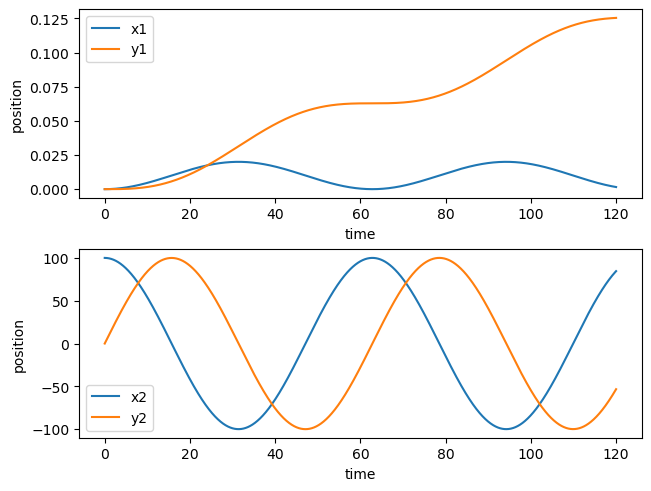

In [190]:
import matplotlib.pyplot as plt

# initial conditions
G = 1#6.67e-11
mass1 = 10000
mass2 = 1
distance = 100
velocity = np.sqrt(G * mass1 / distance)  # Initial tangential velocity for a circular orbit, 10 in this case (wikipedia)

# initial state with body1 at origin, body2 at distance with tangential velocity
u_0 = np.array([0, 0, distance, 0, 0, 0, 0, velocity])

# Simulation parameters
t_0 = 0
t_end = 120
dt = 0.01

ode = PlanetaryMotion(G=G, masses=np.array([mass1, mass2]))
eulerCromer = EulerCromer(ode)
integrator = Integrator(ode, eulerCromer)
times, states = integrator.integrate([t_0, t_end], dt, u_0)
# subplots 2
fig, axs = plt.subplots(2, 1, constrained_layout=True)
axs[0].plot(times,states[:,0],label='x1')
axs[0].plot(times,states[:,1],label='y1')
axs[0].set_xlabel('time')
axs[0].set_ylabel('position')
axs[0].legend()
axs[1].plot(times,states[:,2],label='x2')
axs[1].plot(times,states[:,3],label='y2')
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].legend()
plt.show()

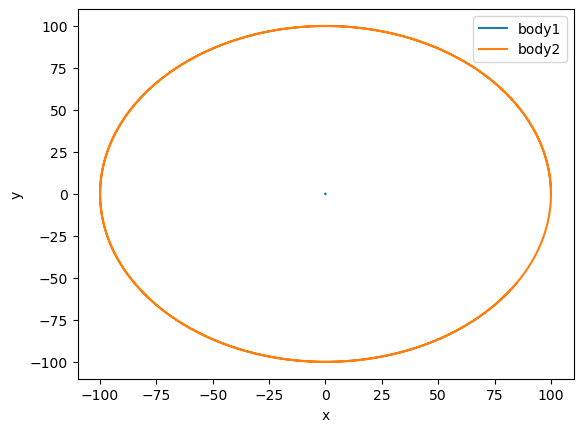

In [191]:
# show the orbit
plt.plot(states[:,0],states[:,1],label='body1')
plt.plot(states[:,2],states[:,3],label='body2')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### Energy Conservation
If you implemented the above correctly, your particle(s) should be moving in a stable, repeating, circular trajectory.  Now try again with Euler's method rather than Euler-Cromer.  What is happening here?  It turns out that Euler's method does not conserve energy.  We can illustrate this directly by computing the total energy of the system as a function of time.  There are two reservoirs of energy in this system: the gravitational potential energy, which is given by
$$
T = -\sum_{i=1}^N \sum_{k=1,i\neq k}^N G \frac{m_i m_k}{|\mathbf{r}_{ik}|}
$$
and the kinetic energy
$$
K = \sum_{i=1}^N \frac{1}{2} m_i v_i^2
$$
**Compute and plot $T + K$ at every time step for both the Euler-Cromer and Euler's method, and comment whether each method conserves energy**.


In [192]:
class Euler:
    def __init__(self, ode):
        self.ode = ode
        pass   
    
    def step(self,t,dt,u_0):
        u_1 = u_0 + dt*self.ode.rhs(t,u_0)
        return u_1
    
def compute_energy(masses, state):
    '''
    Compute the total energy of the system using the provided states and masses.
    '''
    N = len(masses)
    G = 1# 6.67430e-11  # gravitational constant

    # Extract positions and velocities from the state
    positions = state[:2*N].reshape((N, 2)) # reshape for easier loop access
    velocities = state[2*N:].reshape((N, 2))

    # Compute gravitational potential energy
    T = 0
    for i in range(N): # loop over all particles
        for k in range(N): # loop over all particles
            if i != k: # if the particles are not the same
                r_ik = np.linalg.norm(positions[i] - positions[k]) # distance between particles i and k
                T -= G * masses[i] * masses[k] / r_ik # add the potential energy to the total

    # Compute kinetic energy
    K = 0
    for i in range(N): # loop over all particles
        K += 0.5 * masses[i] * np.linalg.norm(velocities[i])**2 # add the kinetic energy to the total

    return T + K # return the total energy

In [193]:
import matplotlib.pyplot as plt

# initial conditions
G = 1#6.67e-11
mass1 = 10000
mass2 = 1
distance = 100
velocity = np.sqrt(G * mass1 / distance)  # Initial tangential velocity for a circular orbit, 10 in this case (wikipedia)

# initial state with body1 at origin, body2 at distance with tangential velocity
u_0 = np.array([0, 0, distance, 0, 0, 0, 0, velocity])

# Simulation parameters
t_0 = 0
t_end = 120
dt = 0.01

ode_ec = PlanetaryMotion(G=G, masses=np.array([mass1, mass2]))
eulerCromer = EulerCromer(ode_ec)
integrator_ec = Integrator(ode_ec, eulerCromer)
times_ec, states_ec = integrator_ec.integrate([t_0, t_end], dt, u_0)

ode_e = PlanetaryMotion(G=G, masses=np.array([mass1, mass2]))
euler = Euler(ode_e)
integrator_e = Integrator(ode_e, euler)
times_e, states_e = integrator_e.integrate([t_0, t_end], dt, u_0)

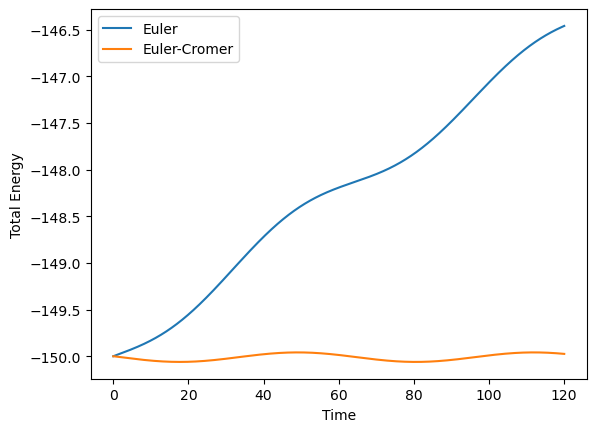

In [194]:
masses = np.array([mass1, mass2])
energies_ec = [compute_energy(masses, states_ec[t]) for t in range(len(times_ec))] # compute the energy at each time step
energies_e = [compute_energy(masses, states_e[t]) for t in range(len(times_e))]
# plot the total energy
plt.plot(times_e, energies_e, label='Euler')
plt.plot(times_ec, energies_ec, label='Euler-Cromer')
plt.xlabel('Time')
plt.ylabel('Total Energy')
plt.legend()
plt.show()

The plot above shows that, over time, the energy of the system is not conserved when using Euler's method.  This can be seen in the increasing energy of the system over time.  This is not the case for Euler-Cromer, which conserves energy exactly (in theory). Euler-cromer is able to conserve energy because it updates the velocity before the position, which means that the position is updated using the already updated velocity.  This means that the energy of the system can be conserved exactly.  This is not the case for Euler's method, which updates the position before the velocity.

### 3-body problem
**Add a third particle to the system**.  It may require a little bit of trial and error to find a stable trajectory (HINT: One stable configuration would add a particle 3 that is somehow symmetric with particle 2.  Explore modifications to the mass and initial conditions to see what kinds of things can happen to our little planets.  

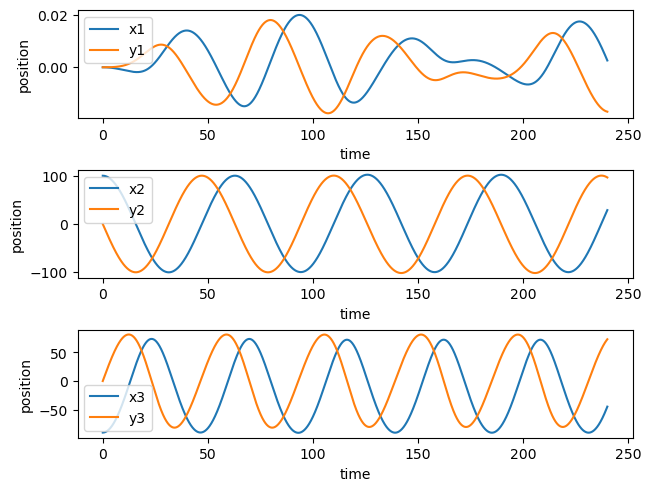

In [212]:
# 3 bodies
# initial conditions
G = 1#6.67e-11
mass1 = 10000
mass2 = 1
mass3 = 1
distance = 100
velocity = np.sqrt(G * mass1 / distance)  # Initial tangential velocity for a circular orbit, 10 in this case (wikipedia)

# initial state with body1 at origin, body2 at distance with tangential velocity [x1,y1,x2,y2,x3,y3,vx1,vy1,vx2,vy2,vx3,vy3]
u_0 = np.array([0, 0, distance, 0, -distance+10, 0, 0, 0, 0, -velocity, 0, velocity])
#              [x1,y1,  x2,     y2,   x3,    y3,vx1,vy1,vx2,  vy2,   vx3,vy3]
# Simulation parameters
t_0 = 0
t_end = 240
dt = 0.01

ode = PlanetaryMotion(G=G, masses=np.array([mass1, mass2, mass3]))
eulerCromer = EulerCromer(ode)
integrator = Integrator(ode, eulerCromer)
times, states = integrator.integrate([t_0, t_end], dt, u_0)

# subplots 3 bodies
fig, axs = plt.subplots(3, 1, constrained_layout=True)
axs[0].plot(times,states[:,0],label='x1')
axs[0].plot(times,states[:,1],label='y1')
axs[0].set_xlabel('time')
axs[0].set_ylabel('position')
axs[0].legend()
axs[1].plot(times,states[:,2],label='x2')
axs[1].plot(times,states[:,3],label='y2')
axs[1].set_xlabel('time')
axs[1].set_ylabel('position')
axs[1].legend()
axs[2].plot(times,states[:,4],label='x3')
axs[2].plot(times,states[:,5],label='y3')
axs[2].set_xlabel('time')
axs[2].set_ylabel('position')
axs[2].legend()
plt.show()

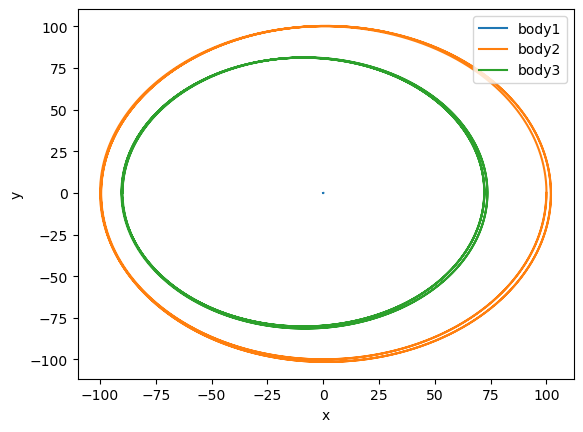

In [213]:
# show trajectories of all bodies on the same plot
plt.plot(states[:,0],states[:,1],label='body1')
plt.plot(states[:,2],states[:,3],label='body2')
plt.plot(states[:,4],states[:,5],label='body3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

---